# Amazon Review Data 활용하기
1. 데이터셋 버전
  - 2013 버전([링크](http://snap.stanford.edu/data/web-Amazon-links.html))
  - 2014 버전([링크](https://jmcauley.ucsd.edu/data/amazon/))
  - 2018 버전([링크](https://nijianmo.github.io/amazon/index.html))
2. 2018버전 데이터셋 정보
  - reviews(ratings, text, helpfulness votes)
  - product metadata(descriptions, category information, price band and image features)
  - links(also viewed/also bought graphs)
  - 이외 추가 정보는 웹사이트 참고
  - 최근(2020-08-07)까지 업데이트된 내용이 있다
3. 데이터셋 크기가 매우 크기 때문에, `Complete review data`보다 `Small subsets 데이터`를 먼저 사용하는 것을 추천한다


## Download data

### 1. wget command를 활용한다

In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz

--2021-01-21 04:56:47--  http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7010521 (6.7M) [application/octet-stream]
Saving to: ‘meta_Computers.json.gz’

meta_Computers.json 100%[===================>]   6.69M  18.6MB/s    in 0.4s    

2021-01-21 04:56:48 (18.6 MB/s) - ‘meta_Computers.json.gz’ saved [7010521/7010521]



In [3]:
### load the meta data
data = []
with gzip.open('meta_Computers.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

18772
{'description': ['Brand new. Still in factory-sealed plastic.'], 'title': 'Kelby Training DVD: The Adobe Photoshop CS5 7-Point System for Camera Raw By Scott Kelby', 'image': ['https://images-na.ssl-images-amazon.com/images/I/31IlLImCVJL._SS40_.jpg'], 'brand': 'Kelby Training', 'rank': ['>#654,681 in Electronics (See Top 100 in Electronics)'], 'main_cat': 'Computers', 'date': 'December 2, 2011', 'asin': '0321732960'}


In [4]:
# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)
print(len(df))

18772


In [ ]:
df.head()

In [6]:
### remove rows with unformatted title (i.e. some 'title' may still contain html style content)
df3 = df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
df5 = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print(len(df4))
print(len(df5))

135
18637


In [ ]:
# how those unformatted rows look like
df4.iloc[0]

### 2. 직접 다운로드 한다

  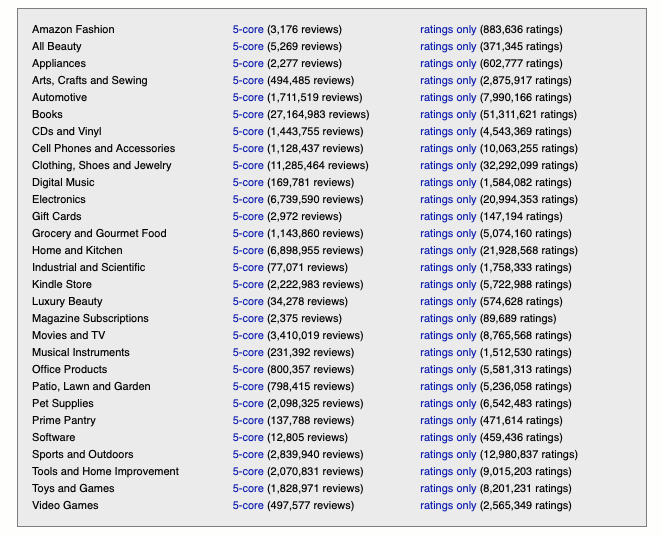

In [8]:
import os, json
import pandas as pd

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
path = '/content/drive/MyDrive/data/amazon_reviews'

#### Read CSV file for ratings only
- (item, user, rating, timestamp)

In [11]:
ratings_df = pd.read_csv(os.path.join(path, 'Software.csv'), header=None, names=['item','user','rating','timestamp'], encoding='utf-8')

In [12]:
print(ratings_df.shape)
print(ratings_df.head())

(459436, 4)
         item            user  rating   timestamp
0  0077613252  A240ORQ2LF9LUI     4.0  1394496000
1  0077613252  A1YCCU0YRLS0FE     4.0  1393113600
2  0077613252  A1BJHRQDYVAY2J     1.0  1392595200
3  0077613252   APRDVZ6QBIQXT     3.0  1392595200
4  0077775473  A2JZTTBSLS1QXV     5.0  1381708800


#### Read JSON file
  - users and items with reviews each
  - 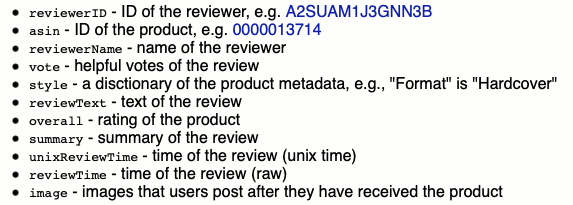

In [13]:
data = []
with open(os.path.join(path, 'Software_5.json'), 'r', encoding='utf-8') as f:
    for l in f:
        data.append(json.loads(l.strip()))

In [14]:
all_df = pd.DataFrame.from_dict(data)
print(all_df.shape)
print(all_df.columns)

(12805, 12)
Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image'],
      dtype='object')


In [15]:
all_df = all_df[['reviewerID', 'asin', 'vote', 'reviewText', 'overall']]
print(all_df.head())

       reviewerID  ... overall
0  A38NELQT98S4H8  ...     4.0
1  A3QJU4FEN8PQSZ  ...     4.0
2   ACJT8MUC0LRF0  ...     5.0
3   AYUF7YETYOLNX  ...     5.0
4  A31ICLWQ9CSHRS  ...     5.0

[5 rows x 5 columns]


In [16]:
all_df.head()

,reviewerID,asin,vote,reviewText,overall
0,A38NELQT98S4H8,0321719816,NaN,I've been using Dreamweaver (and it's predeces...,4.0
1,A3QJU4FEN8PQSZ,0321719816,NaN,"The demo is done with the PC version, with ref...",4.0
2,ACJT8MUC0LRF0,0321719816,3,If you've been wanting to learn how to create ...,5.0
3,AYUF7YETYOLNX,0321719816,NaN,I've been creating websites with Dreamweaver f...,5.0
4,A31ICLWQ9CSHRS,0321719816,NaN,I decided (after trying a number of other prod...,5.0


## Analyze data

1. `reviewer`와 `item` unique수
2. `reviewer`가 평균 review를 준 item 수

In [17]:
# number of unique reviewers
print(len(all_df['reviewerID'].unique()))
# number of unique items
print(len(all_df['asin'].unique()))

1826
802


In [18]:
reviewer_info_df = pd.concat([all_df.groupby(by='reviewerID')['asin'].count(), 
                              all_df.groupby(by='reviewerID')['overall'].mean()], axis=1)
reviewer_info_df.columns = ['number_of_items','average_ratings']
print(reviewer_info_df.head())
print(reviewer_info_df.shape)

                number_of_items  average_ratings
reviewerID                                      
A100UD67AHFODS                5         4.800000
A105S56ODHGJEK               29         3.689655
A1075X1Q4M3S78                5         5.000000
A10C5CJK1YKGV0               10         4.100000
A10CRW7XRJBJ2G                5         3.200000
(1826, 2)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2262561240>,
      dtype=object)

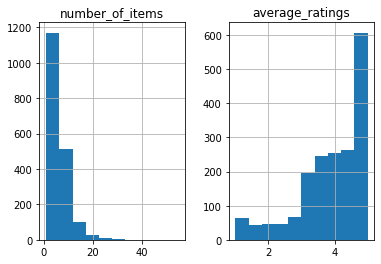

In [19]:
# review를 쓴 평균 item 수, item의 평균 평점
reviewer_info_df.hist()

## Preprocess text data

In [20]:
import re

In [21]:
removal_list =  "‘, ’, ◇, ‘, ”,  ’, ', ·, \“, ·, △, ●,  , ■, (, ), \", >>, `, /, -,∼,=,ㆍ<,>, .,?, !,【,】, …, ◆,%"

def preprocess_sent(sentence):
    sentence = re.sub("[.,\'\"’‘”“!?]", "", sentence)
    sentence = re.sub("[^0-9a-zA-Z\\s]", " ", sentence)
    sentence = re.sub("\s+", " ", sentence)
    
    sentence = sentence.translate(str.maketrans(removal_list, ' '*len(removal_list)))
    sentence = sentence.strip()

    return sentence

In [22]:
all_df = all_df[['reviewText','overall']]
all_df.dropna(how='any', inplace=True)
all_df['reviewText'] = all_df['reviewText'].apply(lambda x: preprocess_sent(str(x).replace('\t',' ').replace('\n',' ')))
all_df['reviewText'] = all_df['reviewText'].apply(lambda x: ' '.join(x.split(' ')[:30]))

print(all_df.shape)

(12804, 2)


In [23]:
all_df['num_lengths'] = all_df['reviewText'].apply(lambda x: len(x.split(' ')))
all_df = all_df[all_df.num_lengths > 10]

In [24]:
all_df.drop('num_lengths', axis=1, inplace=True)
print(all_df.shape)
all_df.to_csv(os.path.join(path, 'Software_reviewText.csv'), sep='\t', encoding='utf-8')

(11273, 2)


In [25]:
all_df['reviewText'].iloc[0]

'Ive been using Dreamweaver and its predecessor Macromedias UltraDev for many years For someone who is an experienced web designer this course is a high level review of the CS5'

In [26]:
all_df['overall'].iloc[0]

4.0

## Load dataset

In [27]:
import torch
from torchtext import data
from torchtext import datasets
import random

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField()

In [28]:
fields = [(None, None), ('text', TEXT), ('label', LABEL)]

# Load Custom dataset
training_data = data.TabularDataset(path=os.path.join(path,'Software_reviewText.csv'),
                                  format ='tsv', fields = fields, skip_header = True)

# Print sample text
print(vars(training_data.examples[0]))

{'text': ['I', 've', 'been', 'using', 'Dreamweaver', 'and', 'its', 'predecessor', 'Macromedias', 'UltraDev', 'for', 'many', 'years', 'For', 'someone', 'who', 'is', 'an', 'experienced', 'web', 'designer', 'this', 'course', 'is', 'a', 'high', 'level', 'review', 'of', 'the', 'CS5'], 'label': '4.0'}


In [29]:
MAX_VOCAB_SIZE = 25000

# Pre-trained embedding을 사용하고자 한다면 아래를 실행하자
# TEXT.build_vocab(train_data, 
#                  max_size = MAX_VOCAB_SIZE, 
#                  vectors = "glove.6B.100d", 
#                  unk_init = torch.Tensor.normal_)

TEXT.build_vocab(training_data, 
                 max_size = MAX_VOCAB_SIZE)

LABEL.build_vocab(training_data)

In [30]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f220fab8bf8>, {'5.0': 0, '4.0': 1, '3.0': 2, '1.0': 3, '2.0': 4})


In [31]:
BATCH_SIZE = 64

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, valid_data = training_data.split(split_ratio=0.8, random_state = random.seed(1234))

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    sort_key = lambda x: len(x.text),
    sort_within_batch=False,
    batch_size = BATCH_SIZE
    )

## Model Architecture

- [PyTorch Text Classification](https://github.com/bentrevett/pytorch-sentiment-analysis)
- Yoon Kim, 2014, Convolutional Neural Networks for Sentence Classification([논문 링크](https://arxiv.org/pdf/1408.5882.pdf))
  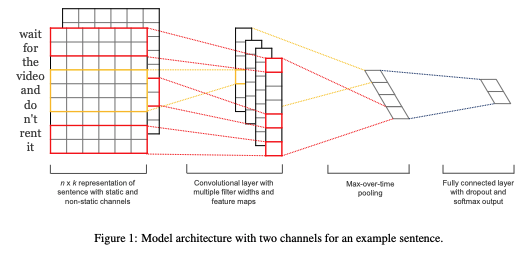

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        text = text.permute(1, 0)

        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [33]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,389,505 trainable parameters


In [35]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train model

In [36]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# model = model.to(device)
# criterion = criterion.to(device)

In [37]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [38]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text)
        
        loss = criterion(predictions, batch.label)
        
        acc = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text)
            
            loss = criterion(predictions, batch.label)
            
            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [40]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'cnn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.502 | Train Acc: 38.91%
	 Val. Loss: 1.337 |  Val. Acc: 43.71%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 1.336 | Train Acc: 45.34%
	 Val. Loss: 1.304 |  Val. Acc: 43.49%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 1.269 | Train Acc: 47.89%
	 Val. Loss: 1.295 |  Val. Acc: 44.79%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 1.194 | Train Acc: 51.14%
	 Val. Loss: 1.237 |  Val. Acc: 47.02%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 1.135 | Train Acc: 54.15%
	 Val. Loss: 1.227 |  Val. Acc: 48.44%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 1.065 | Train Acc: 57.61%
	 Val. Loss: 1.206 |  Val. Acc: 50.55%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 1.002 | Train Acc: 59.90%
	 Val. Loss: 1.172 |  Val. Acc: 51.09%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.927 | Train Acc: 63.62%
	 Val. Loss: 1.170 |  Val. Acc: 51.30%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.831 | Train Acc: 67.84%
	 Val. Loss: 1.183 |  Val. Acc: 50.25%
Epoch: 10 | Epoch Ti

## Evaluate model

In [42]:
model.load_state_dict(torch.load('cnn-model.pt'))

import spacy
nlp = spacy.load('en')

def predict_class(model, sentence, min_len = 4):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed)
    tensor = tensor.unsqueeze(1)
    preds = model(tensor)
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [43]:
pred_class = predict_class(model, "best item")
print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')

Predicted class is: 0 = 5.0


In [44]:
pred_class = predict_class(model, "worst item")
print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')

Predicted class is: 3 = 1.0


In [45]:
pred_class = predict_class(model, "it was best item, but requires to be fixed")
print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')

Predicted class is: 0 = 5.0


## (참고) BERT Embedding 가져오기
1. word2vec
2. [fastText](https://fasttext.cc/)
3. [Glove](https://nlp.stanford.edu/projects/glove/)
4. Huggingface 참고([링크](https://huggingface.co/transformers/pretrained_models.html))


In [ ]:
# embedding + meta vector -> 512dim + 100dim -> 612 dim
# rating 1,2,3,4,5 -> prediction = 3 (40%)

In [46]:
!pip install transformers

     |████████████████████████████████| 1.8MB 7.6MB/s 
     |████████████████████████████████| 2.9MB 15.4MB/s 
     |████████████████████████████████| 890kB 63.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=7ec5c5d0f9c2ad76957646cf56c5fe036b367efbb67defeb67056fba0e966a64
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [47]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [48]:
import re
import warnings

import numpy as np
import torch
from nltk import tokenize
from transformers import BertModel, BertTokenizer

warnings.filterwarnings("ignore")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_embedding(sentence):
    sent_vectors = []
    for sent in tokenize.sent_tokenize(sentence):
        text = "[CLS] " + sent + " [SEP]"
        tokenized_text = tokenizer.tokenize(text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        segments_ids = [1] * len(tokenized_text)

        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensor = torch.tensor([segments_ids])

        with torch.no_grad():
            outputs = model(tokens_tensor, segments_tensor)
            encoded_layers = outputs[0] # last hidden state          
            sentence_embedding = torch.mean(encoded_layers[0], dim=0)
            sent_vectors.append(sentence_embedding.detach().numpy())

    return np.array(sent_vectors).mean(axis=0)


In [50]:
bert_embedding = get_embedding('hello, today is thursday')

In [51]:
len(bert_embedding)

768